In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from adversarial_dataset import AdversarialDataset
import os
import matplotlib.pyplot as plt
from torchvision import models
from tqdm.notebook import tqdm
import numpy as np


In [2]:
class TensorToDevice(object):
    def __init__(self, device):
        self.device = device
        
    def __call__(self, image):
        image = image.to(self.device)
        return image

In [3]:
def show_image(datarow):
    permuted = torch.permute(datarow[0].cpu(), (1, 2, 0))
    plt.title(datarow[1])
    plt.imshow(permuted)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = transforms.Compose([
    transforms.ToTensor(),
    TensorToDevice(device),
    transforms.Normalize(mean=mean, std=std)
])

adv_transform = transforms.Compose([
    transforms.ToTensor(),
    TensorToDevice(device)
])

noise_transform = transforms.Compose([
    transforms.ToTensor()
])

In [6]:
dataset = AdversarialDataset(annotation_file="images.csv", 
                             categories_file="categories.csv", 
                             img_dir="images", 
                             noise_dir="adversarial_noise_untargeted", 
                             img_transform=transform, 
                             noise_transform=noise_transform)

dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

<h3> Generate C&W images </h3>

In [9]:
import cw_impl.cw as cw
import math
from torchvision.utils import save_image 

def generate_cw_samples(model, dataloader, save_dir, save_to_disk=True):
    n_original_correct, n_adv_correct = 0, 0
    
    inputs_box = (min((0 - m) / s for m, s in zip(mean, std)), max((1 - m) / s for m, s in zip(mean, std)))
    
    adversary = cw.L2Adversary(targeted=False, 
                               confidence=0.0,
                               search_steps=5,
                               abort_early=True,
                               box=inputs_box)
    
    model.eval()
    for i_batch, (inputs, labels, _, input_ids) in enumerate(dataloader):
        print(f"Batch {i_batch+1}/{math.ceil(1000/32)}")
        labels = labels.to(device)
        adversarial_examples = adversary(model, inputs, labels, to_numpy=False)
        adversarial_examples = adversarial_examples.to(device)
        
        adv_output = model(adversarial_examples)
        original_output = model(inputs)
        
        _, adv_preds = torch.max(adv_output, dim=1)
        n_adv_correct += torch.sum(adv_preds == labels)
        
        _, preds = torch.max(original_output, dim=1)
        n_original_correct += torch.sum(preds == labels)
        
        print(f"Total original correct: {n_original_correct} at batch {i_batch+1}")
        print(f"Total adversarial correct: {n_adv_correct} at batch {i_batch+1}")
        
        noise = adversarial_examples - inputs
        
        noise = noise.cpu().numpy()
        
        if save_to_disk:
            for i in range(adversarial_examples.shape[0]):
                with open(os.path.join(save_dir, input_ids[i] + ".npy"), 'wb') as f:
                    np.save(f, noise[i])
                
                
                # save_image(adversarial_examples[i], os.path.join(save_dir, input_ids[i] + ".png"))
        
generate_cw_samples(model, dataloader, "adversarial_noise_untargeted")
        

Batch 1/32
Total original correct: 29 at batch 1
Total adversarial correct: 0 at batch 1
Batch 2/32
Total original correct: 60 at batch 2
Total adversarial correct: 0 at batch 2
Batch 3/32
Total original correct: 91 at batch 3
Total adversarial correct: 0 at batch 3
Batch 4/32
Total original correct: 122 at batch 4
Total adversarial correct: 0 at batch 4
Batch 5/32
Total original correct: 151 at batch 5
Total adversarial correct: 1 at batch 5
Batch 6/32
Total original correct: 182 at batch 6
Total adversarial correct: 1 at batch 6
Batch 7/32
Total original correct: 213 at batch 7
Total adversarial correct: 1 at batch 7
Batch 8/32
Total original correct: 244 at batch 8
Total adversarial correct: 1 at batch 8
Batch 9/32
Total original correct: 276 at batch 9
Total adversarial correct: 1 at batch 9
Batch 10/32
Total original correct: 306 at batch 10
Total adversarial correct: 1 at batch 10
Batch 11/32
Total original correct: 337 at batch 11
Total adversarial correct: 1 at batch 11
Batch 1

In [8]:
model.eval()
n_correct_img = 0
n_correct_adv = 0
for img, noise, label, _, _ in tqdm(dataloader):
    noise = noise.to(device)
    label = label.to(device)
    
    output_img = model(img)
    output_adv = model(img + noise)

    _, preds_img = torch.max(output_img, dim=1)
    n_correct_img += torch.sum(preds_img == label)
    
    _, preds_adv = torch.max(output_adv, dim=1)
    n_correct_adv += torch.sum(preds_adv == label)

print(n_correct_img/len(dataset))

print(n_correct_adv/len(dataset))


  0%|          | 0/32 [00:00<?, ?it/s]

tensor(0.9510, device='cuda:0')
tensor(0.0010, device='cuda:0')


In [ ]:
adversarial_examples[0].shape, inputs.shape

In [ ]:
diff.device, inputs.device

In [16]:
torch.min(dataset[0][1]), torch.max(dataset[0][1])

(tensor(-0.0049), tensor(0.0049))

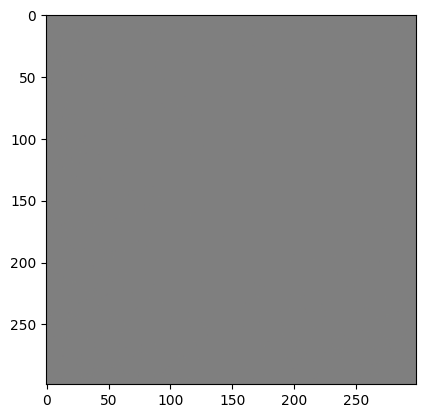

In [27]:
show_image(((dataset[0][1] + .5), ""))

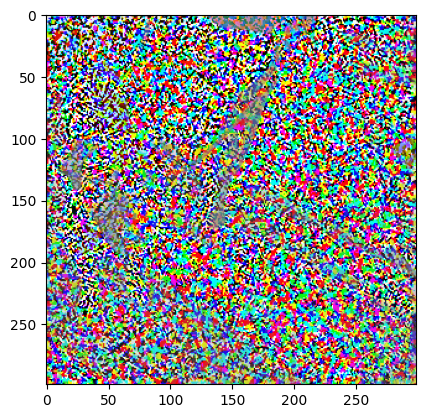

In [44]:
def minmax_scaler(arr, *, vmin=0, vmax=1):
    arr_min, arr_max = torch.min(arr), torch.max(arr)
    return ((arr - arr_min) / (arr_max - arr_min)) * (vmax - vmin) + vmin


img = dataset[2][1]

show_image((minmax_scaler(img), ""))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


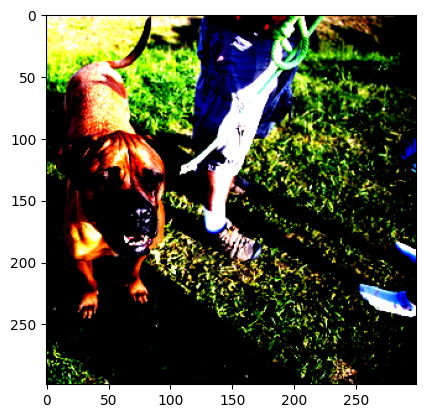

In [43]:
show_image((dataset[2][0], ""))